This notebook contains a generator class for Keras called `BSONIterator` that can read directly from the BSON data. You can use it in combination with `ImageDataGenerator` for doing data augmentation.

In [28]:
import os, sys, math, io
import numpy as np
import pandas as pd
import multiprocessing as mp
import bson
import struct

%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf

from collections import defaultdict
from tqdm import *

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", "../../dataset"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

category_names.csv
train.bson
train_example.bson



In [29]:
keras.__version__, tf.__version__

('2.0.8', '1.3.0')

In [30]:
data_dir = "../../dataset/"

train_bson_path = os.path.join(data_dir, "train.bson")
num_train_products = 7069896

# train_bson_path = os.path.join(data_dir, "train_example.bson")
# num_train_products = 82

test_bson_path = os.path.join(data_dir, "test.bson")
num_test_products = 1768182

# Part 1: Create lookup tables

The generator uses several lookup tables that describe the layout of the BSON file, which products and images are part of the training/validation sets, and so on.

You only need to generate these tables once, as they get saved to CSV files. If you already have these CSV files, skip to part 2.

## Lookup table for categories

In [31]:
categories_path = os.path.join(data_dir, "category_names.csv")
categories_df = pd.read_csv(categories_path, index_col="category_id")

# Maps the category_id to an integer index. This is what we'll use to
# one-hot encode the labels.
categories_df["category_idx"] = pd.Series(range(len(categories_df)), index=categories_df.index)

categories_df.to_csv("categories.csv")
categories_df.head()

,category_level1,category_level2,category_level3,category_idx
category_id,,,,
1000021794,ABONNEMENT / SERVICES,CARTE PREPAYEE,CARTE PREPAYEE MULTIMEDIA,0
1000012764,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI FUMEUR,1
1000012776,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,ABRI VELO - ABRI MOTO,2
1000012768,AMENAGEMENT URBAIN - VOIRIE,AMENAGEMENT URBAIN,FONTAINE A EAU,3
1000012755,AMENAGEMENT URBAIN - VOIRIE,SIGNALETIQUE,PANNEAU D'INFORMATION EXTERIEUR,4


Create dictionaries for quick lookup of `category_id` to `category_idx` mapping.

In [32]:
def make_category_tables():
    cat2idx = {}
    idx2cat = {}
    for ir in categories_df.itertuples():
        category_id = ir[0]
        category_idx = ir[4]
        cat2idx[category_id] = category_idx
        idx2cat[category_idx] = category_id
    return cat2idx, idx2cat

In [33]:
cat2idx, idx2cat = make_category_tables()

In [34]:
# Test if it works:
cat2idx[1000012755], idx2cat[4]

(4, 1000012755)

## Read the BSON files

We store the offsets and lengths of all items, allowing us random access to the items later.

Inspired by code from: https://www.kaggle.com/vfdev5/random-item-access

Note: this takes a few minutes to execute, but we only have to do it once (we'll save the table to a CSV file afterwards).

In [35]:
def read_bson(bson_path, num_records, with_categories):
    rows = {}
    with open(bson_path, "rb") as f, tqdm(total=num_records) as pbar:
        offset = 0
        while True:
            item_length_bytes = f.read(4)
            if len(item_length_bytes) == 0:
                break

            length = struct.unpack("<i", item_length_bytes)[0]

            f.seek(offset)
            item_data = f.read(length)
            assert len(item_data) == length

            item = bson.BSON(item_data).decode()
            product_id = item["_id"]
            num_imgs = len(item["imgs"])

            row = [num_imgs, offset, length]
            if with_categories:
                row += [item["category_id"]]
            rows[product_id] = row

            offset += length
            f.seek(offset)
            pbar.update()

    columns = ["num_imgs", "offset", "length"]
    if with_categories:
        columns += ["category_id"]

    df = pd.DataFrame.from_dict(rows, orient="index")
    df.index.name = "product_id"
    df.columns = columns
    df.sort_index(inplace=True)
    return df

In [36]:
%time train_offsets_df = read_bson(train_bson_path, num_records=num_train_products, with_categories=True)

100%|██████████| 7069896/7069896 [03:47<00:00, 31034.29it/s]


CPU times: user 1min 34s, sys: 30.9 s, total: 2min 5s
Wall time: 3min 55s


In [37]:
train_offsets_df.head()

,num_imgs,offset,length,category_id
product_id,,,,
0,1,0,6979,1000010653
1,1,6979,7318,1000010653
2,1,14297,5455,1000004079
3,1,19752,4580,1000004141
4,1,24332,6346,1000015539


In [38]:
train_offsets_df.to_csv("train_offsets.csv")

In [39]:
# How many products?
len(train_offsets_df)

7069896

In [40]:
# How many categories?
len(train_offsets_df["category_id"].unique())

5270

In [41]:
# How many images in total?
train_offsets_df["num_imgs"].sum()

12371293

## Create a random train/validation split

We split on products, not on individual images. Since some of the categories only have a few products, we do the split separately for each category.

This creates two new tables, one for the training images and one for the validation images. There is a row for every single image, so if a product has more than one image it occurs more than once in the table.

In [42]:
def make_val_set(df, split_percentage=0.2, drop_percentage=0.):
    # Find the product_ids for each category.
    category_dict = defaultdict(list)
    for ir in tqdm(df.itertuples()):
        category_dict[ir[4]].append(ir[0])

    train_list = []
    val_list = []
    with tqdm(total=len(df)) as pbar:
        for category_id, product_ids in category_dict.items():
            category_idx = cat2idx[category_id]

            # Randomly remove products to make the dataset smaller.
            keep_size = int(len(product_ids) * (1. - drop_percentage))
            if keep_size < len(product_ids):
                product_ids = np.random.choice(product_ids, keep_size, replace=False)

            # Randomly choose the products that become part of the validation set.
            val_size = int(len(product_ids) * split_percentage)
            if val_size > 0:
                val_ids = np.random.choice(product_ids, val_size, replace=False)
            else:
                val_ids = []

            # Create a new row for each image.
            for product_id in product_ids:
                row = [product_id, category_idx]
                for img_idx in range(df.loc[product_id, "num_imgs"]):
                    if product_id in val_ids:
                        val_list.append(row + [img_idx])
                    else:
                        train_list.append(row + [img_idx])
                pbar.update()
                
    columns = ["product_id", "category_idx", "img_idx"]
    train_df = pd.DataFrame(train_list, columns=columns)
    val_df = pd.DataFrame(val_list, columns=columns)   
    return train_df, val_df

Create a 80/20 split. Also drop 90% of all products to make the dataset more manageable. (Note: if `drop_percentage` > 0, the progress bar doesn't go all the way.)

In [64]:
train_images_df, val_images_df = make_val_set(train_offsets_df, split_percentage=0.2, 
                                              drop_percentage=0.8)

7069896it [00:05, 1276033.10it/s]
 20%|█▉        | 1410843/7069896 [00:32<02:09, 43858.61it/s]


In [65]:
train_images_df.head()

,product_id,category_idx,img_idx
0,19046002,619,0
1,5513582,619,0
2,17565568,619,0
3,18531940,619,0
4,19123021,619,0


In [66]:
val_images_df.head()

,product_id,category_idx,img_idx
0,1456241,619,0
1,13206754,619,0
2,1521866,619,0
3,1521866,619,1
4,3954678,619,0


In [67]:
print("Number of training images:", len(train_images_df))
print("Number of validation images:", len(val_images_df))
print("Total images:", len(train_images_df) + len(val_images_df))

('Number of training images:', 1978504)
('Number of validation images:', 490393)
('Total images:', 2468897)


Are all categories represented in the train/val split? (Note: if the drop percentage is high, then very small categories won't have enough products left to make it into the validation set.)

In [68]:
len(train_images_df["category_idx"].unique()), len(val_images_df["category_idx"].unique())

(5270, 4835)

Quickly verify that the split really is approximately 80-20:

In [69]:
category_idx = 619
num_train = np.sum(train_images_df["category_idx"] == category_idx)
num_val = np.sum(val_images_df["category_idx"] == category_idx)
print (float(num_val) / num_train)

0.268011527378


Close enough. ;-) Remember that we split on products but not all products have the same number of images, which is where the slightly discrepancy comes from. (Also, there tend to be fewer validation images if `drop_percentage` > 0.)

Save the lookup tables as CSV so that we don't need to repeat the above procedure again.

In [70]:
train_images_df.to_csv("train_images.csv")
val_images_df.to_csv("val_images.csv")

# Part 2: The generator

First load the lookup tables from the CSV files (you don't need to do this if you just did all the steps from part 1).

In [71]:
categories_df = pd.read_csv("categories.csv", index_col=0)
cat2idx, idx2cat = make_category_tables()

train_offsets_df = pd.read_csv("train_offsets.csv", index_col=0)
train_images_df = pd.read_csv("train_images.csv", index_col=0)
val_images_df = pd.read_csv("val_images.csv", index_col=0)

IOError: File categories.csv does not exist

The Keras generator is implemented by the `BSONIterator` class. It creates batches of images (and their one-hot encoded labels) directly from the BSON file. It can be used with multiple workers.

**Note:** For fastest results, put the train.bson and test.bson files on a fast drive (SSD).

See also the code in: https://github.com/fchollet/keras/blob/master/keras/preprocessing/image.py

In [72]:
from keras.preprocessing.image import Iterator
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

class BSONIterator(Iterator):
    def __init__(self, bson_file, images_df, offsets_df, num_class,
                 image_data_generator, lock, target_size=(180, 180), 
                 with_labels=True, batch_size=32, shuffle=False, seed=None):

        self.file = bson_file
        self.images_df = images_df
        self.offsets_df = offsets_df
        self.with_labels = with_labels
        self.samples = len(images_df)
        self.num_class = num_class
        self.image_data_generator = image_data_generator
        self.target_size = tuple(target_size)
        self.image_shape = self.target_size + (3,)

        print("Found %d images belonging to %d classes." % (self.samples, self.num_class))

        super(BSONIterator, self).__init__(self.samples, batch_size, shuffle, seed)
        self.lock = lock

    def _get_batches_of_transformed_samples(self, index_array):
        batch_x = np.zeros((len(index_array),) + self.image_shape, dtype=K.floatx())
        if self.with_labels:
            batch_y = np.zeros((len(batch_x), self.num_class), dtype=K.floatx())

        for i, j in enumerate(index_array):
            # Protect file and dataframe access with a lock.
            with self.lock:
                image_row = self.images_df.iloc[j]
                product_id = image_row["product_id"]
                offset_row = self.offsets_df.loc[product_id]

                # Read this product's data from the BSON file.
                self.file.seek(offset_row["offset"])
                item_data = self.file.read(offset_row["length"])

            # Grab the image from the product.
            item = bson.BSON(item_data).decode()
            img_idx = image_row["img_idx"]
            bson_img = item["imgs"][img_idx]["picture"]

            # Load the image.
            img = load_img(io.BytesIO(bson_img), target_size=self.target_size)

            # Preprocess the image.
            x = img_to_array(img)
            x = self.image_data_generator.random_transform(x)
            x = self.image_data_generator.standardize(x)

            # Add the image and the label to the batch (one-hot encoded).
            batch_x[i] = x
            if self.with_labels:
                batch_y[i, image_row["category_idx"]] = 1

        if self.with_labels:
            return batch_x, batch_y
        else:
            return batch_x

    def next(self):
        with self.lock:
            index_array = next(self.index_generator)
        return self._get_batches_of_transformed_samples(index_array)

In [73]:
train_bson_file = open(train_bson_path, "rb")

Because the training and validation generators read from the same BSON file, they need to use the same lock to protect it.

In [74]:
import threading
lock = threading.Lock()

Create a generator for training and a generator for validation.

In [75]:
num_classes = 5270
num_train_images = len(train_images_df)
num_val_images = len(val_images_df)
batch_size = 128

# Tip: use ImageDataGenerator for data augmentation and preprocessing.
train_datagen = ImageDataGenerator()
train_gen = BSONIterator(train_bson_file, train_images_df, train_offsets_df, 
                         num_classes, train_datagen, lock,
                         batch_size=batch_size, shuffle=True)

val_datagen = ImageDataGenerator()
val_gen = BSONIterator(train_bson_file, val_images_df, train_offsets_df,
                       num_classes, val_datagen, lock,
                       batch_size=batch_size, shuffle=True)

Found 1978504 images belonging to 5270 classes.
Found 490393 images belonging to 5270 classes.


How fast is the generator? Create a single batch:

In [76]:
next(train_gen)  # warm-up

%time bx, by = next(train_gen)

CPU times: user 108 ms, sys: 20 ms, total: 128 ms
Wall time: 173 ms


Does it really output images and one-hot encoded class labels? Note that the images are pre-processed (and augmented) and therefore may look weird.

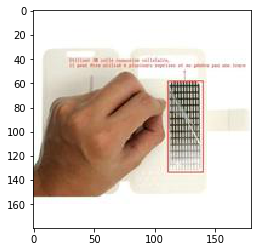

In [77]:
plt.imshow(bx[-1].astype(np.uint8))

In [78]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1                                     TELEPHONIE - GPS
category_level2               MONTRE INTELLIGENTE - MONTRE CONNECTEE
category_level3    HOUSSE MONTRE CONNECTEE - ETUI MONTRE CONNECTE...
category_idx                                                    5091
Name: 1000021535, dtype: object

In [79]:
%time bx, by = next(val_gen)

CPU times: user 132 ms, sys: 12 ms, total: 144 ms
Wall time: 187 ms


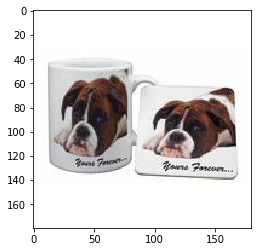

In [80]:
plt.imshow(bx[-1].astype(np.uint8))

In [81]:
cat_idx = np.argmax(by[-1])
cat_id = idx2cat[cat_idx]
categories_df.loc[cat_id]

category_level1    ART DE LA TABLE - ARTICLES CULINAIRES
category_level2                   SERVICE PETIT DEJEUNER
category_level3                     BOL - MUG - MAZAGRAN
category_idx                                         316
Name: 1000002361, dtype: object

# Part 3: Training

Create a very simple Keras model and train it, to test that the generators work.

In [82]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D, GlobalAveragePooling2D

model = Sequential()
model.add(Conv2D(32, 3, padding="same", activation="relu", input_shape=(180, 180, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(256, 3, padding="same", activation="relu"))
model.add(Conv2D(256, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(Conv2D(512, 3, padding="same", activation="relu"))
model.add(Conv2D(512, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())
model.add(GlobalAveragePooling2D())
model.add(Dense(num_classes, activation="softmax"))

model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_31 (Conv2D)           (None, 180, 180, 32)      896       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 90, 90, 32)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 90, 90, 64)        18496     
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 45, 45, 64)        0         
_________________________________________________________________
conv2d_33 (Conv2D)           (None, 45, 45, 128)       73856     
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 45, 45, 128)       147584    
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 22, 22, 128)       0         
__________

In [84]:
# To train the model:

model.fit_generator(train_gen,
                    steps_per_epoch = num_train_images // batch_size,
                    epochs = 5,
                    validation_data = val_gen,
                    validation_steps = num_val_images // batch_size,
                    workers = 4)

Epoch 1/5
10985/15457 [====================>.........] - ETA: 1558s - loss: 3.0257 - acc: 0.4549

KeyboardInterrupt: 

In [ ]:
# To evaluate on the validation set:
#model.evaluate_generator(val_gen, steps=num_val_images // batch_size, workers=8)

# Part 4: Test set predictions

Note: The previous version of this kernel used `BSONIterator` to load the test set images in batches. However, storing the prediction results takes up a huge amount of memory. 

I suggest using a different kind of generator instead, something like the following:

```
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

submission_df = pd.read_csv(data_dir + "sample_submission.csv")
submission_df.head()

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
data = bson.decode_file_iter(open(test_bson_path, "rb"))

with tqdm(total=num_test_products) as pbar:
    for c, d in enumerate(data):
        product_id = d["_id"]
        num_imgs = len(d["imgs"])

        batch_x = np.zeros((num_imgs, 180, 180, 3), dtype=K.floatx())

        for i in range(num_imgs):
            bson_img = d["imgs"][i]["picture"]

            # Load and preprocess the image.
            img = load_img(io.BytesIO(bson_img), target_size=(180, 180))
            x = img_to_array(img)
            x = test_datagen.random_transform(x)
            x = test_datagen.standardize(x)

            # Add the image to the batch.
            batch_x[i] = x

        prediction = model.predict(batch_x, batch_size=num_imgs)
        avg_pred = prediction.mean(axis=0)
        cat_idx = np.argmax(avg_pred)
        
        submission_df.iloc[c]["category_id"] = idx2cat[cat_idx]        
        pbar.update()
        
submission_df.to_csv("my_submission.csv.gz", compression="gzip", index=False)        
```